<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_focal_loss_with_uid_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [1]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

In [2]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


loading drive

In [3]:
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


Loading dataframes

In [4]:
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train_id.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test_id.csv',index_col=[0])
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,C9_std_isna,C10_std_isna,C11_std_isna,C12_std_isna,C13_std_isna,C14_std_isna,D1_mean_isna,D1_std_isna,D2_mean_isna,D2_std_isna,D3_mean_isna,D3_std_isna,D4_mean_isna,D4_std_isna,D5_mean_isna,D5_std_isna,D6_mean_isna,D6_std_isna,D7_mean_isna,D7_std_isna,D8_mean_isna,D8_std_isna,D9_mean_isna,D9_std_isna,D10_mean_isna,D10_std_isna,D11_mean_isna,D11_std_isna,D12_mean_isna,D12_std_isna,D13_mean_isna,D13_std_isna,D14_mean_isna,D14_std_isna,D15_mean_isna,D15_std_isna,V1_mean_isna,V1_std_isna,isFraud,id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,Wnan315.013926-13.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,Wgmail.com325.027551.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,Woutlook.com330.046631.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,Wyahoo.com476.018132-111.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Hgmail.com420.044971.0


Reduce memory useage

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2793.39 MB
Memory usage after optimization is: 678.37 MB
Decreased by 75.7%
Memory usage of dataframe is 2392.90 MB
Memory usage after optimization is: 580.09 MB
Decreased by 75.8%


In [6]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [7]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data,epochs):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0
        self.epochs=epochs
        self.val=0
        self.wts=[]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        if roc_val>self.val:
          self.val=roc_val
          self.epoch=10
          self.wts=self.model.get_weights()
        else:
          self.epoch-=1
        if self.epoch==0:
          self.model.set_weights(self.wts)
          self.model.stop_training = True
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model(dim):
  K.clear_session()


  uid=Input((1,))
  inp=Input((873,))
  emb=Embedding(input_dim=dim,output_dim=4)(uid)
  emb=Flatten()(emb)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  emb=Flatten()(emb)
  x=Concatenate()([emb,x])
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp,uid],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

Adding all datasets

In [8]:
trn_s=trn.shape[0]
df=pd.concat([trn,tst],0).reset_index(drop=True)
del([trn,tst])
gc.collect()


autoenc=pd.read_csv('/content/gdrive/My Drive/fraud/without_id.csv',index_col=[0])
autoenc=reduce_mem_usage(autoenc)

autoenc.columns=[i for i in range(444,444+autoenc.shape[1])]


df=pd.concat([df,autoenc],1)
del([autoenc])
gc.collect()

trn=df.loc[:trn_s-1]
tst=df.loc[trn_s:].reset_index(drop=True)
del([df])
gc.collect()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Memory usage of dataframe is 2151.40 MB
Memory usage after optimization is: 544.13 MB
Decreased by 74.7%


0

In [9]:
categorical=[str(i) for i in range(444)]
trn[categorical]=trn[categorical].astype('uint8')
tst[categorical]=tst[categorical].astype('uint8')

In [19]:
def fl():
    def focal_loss(y_true, y_pred):
        gamma=2
        alpha=0.9
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        pt_1 = K.clip(pt_1, 1e-3, .999)
        pt_0 = K.clip(pt_0, 1e-3, .999)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss

In [20]:
class stocasticensembling(Callback):
  def __init__(self,model_name,alpha1,alpha2,iter_per_epoch,cycle_len,seqs_dict,start_inx=0,save_se_weights=False,folder='/content',**kwargs):
    #save_se_weights: save after each epoch ?

    super(stocasticensembling,self).__init__()
    self.model_count=0
    self.alpha1=alpha1
    self.alpha2=alpha2
    self.clr_iterations=0
    self.cycle_num=cycle_len
    self.cycle_len=cycle_len
    self.iter_per_epoch=iter_per_epoch
    self.iter_per_cycle = self.cycle_len * self.iter_per_epoch
    self.save_se_weights=save_se_weights
    self.start_inx=start_inx
    self.swa_weights=[]
    self.folder=folder
    self.seqs_dict=seqs_dict
    self.model_name=model_name
    self.prob_dict={k: [] for k in self.seqs_dict.keys()}
    self.lrs=[]

  def on_train_end(self,logs={}):
    self.weight_update()
    self.model.set_weights(self.swa_weights)
    self.snapsort()
    for seq_names,probs in self.prob_dict.items():
      self.prob_dict[seq_names]=np.concatenate(probs,axis=-1)
  
  
  def on_epoch_begin(self,epoch,logs=None):
    self.current_epoch=epoch
  
  
  def on_epoch_end(self,epoch,logs=None):
    self.cycle_num+=1
    if (self._t_cycle() !=1) or (epoch == 14):
      return
    self.snapsort()
    self.weight_update()
    self.model_count+=1
  
  
  def on_batch_begin(self,batch,logs=None):
    self.clr_iterations+=1
    lr=self._clr_schedule()
    self.lrs.append(lr)
    K.set_value(self.model.optimizer.lr,lr)
  
  
  def snapsort(self):
    print(self.clr_iterations)
    print(K.eval(self.model.optimizer.lr))
    for seq_name,seq in self.seqs_dict.items():
      self.prob_dict[seq_name].append(self.model.predict(seq,steps=len(seq)))
  
  
  def weight_update(self):
    weights=self.model.get_weights()
    if self.model_count==0:
      self.swa_weights=weights
    for i in range(0,len(weights)):
      self.swa_weights[i]=(self.swa_weights[i]*self.model_count+weights[i])/(self.model_count+1)
  
  
  def _t_cycle(self):
        return (((self.clr_iterations - 1) % self.iter_per_cycle) + 1) / self.iter_per_cycle
  
  
  def _clr_schedule(self):
    return ((1.0 - 1.0 *self._t_cycle()) * self.alpha2) + (1.0 *self._t_cycle() *self.alpha1)

In [22]:
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
splits=KFold(n_splits=5)
gc.collect()
pre=np.zeros((506691,1))
# tst=tst.drop(['isFraud'],1)
for en,(train_index,test_index) in enumerate(tqdm(splits.split(trn))):
  X_train, X_test = trn.loc[train_index], trn.loc[test_index]
  y_train, y_test = X_train['isFraud'], X_test['isFraud']
  ids={}
  for en,id in enumerate(X_train['id'].unique()):
    ids[id]=en+2
  X_train['id']=X_train['id'].map(lambda x: ids.get(x,1))
  X_test['id']=X_test['id'].map(lambda x: ids.get(x,1))
  dim=X_train['id'].nunique()+2
  gc.collect()
  trn_id,tst_id=X_train['id'],X_test['id']
  X_train=X_train.drop(['isFraud','id'],1)
  X_test=X_test.drop(['isFraud','id'],1)
  mod=load_model(dim)
  roc = RocCallback(validation_data=([X_test,tst_id], y_test),epochs=10)
  mod.compile(optimizer=Nadam(),loss=fl())
  es=EarlyStopping(monitor='acu_val',min_delta=0.0001,mode='min',restore_best_weights=True,patience=10)
  seqs_dict={'test':[tst.drop(['id'],1),tst['id'].map(lambda x: ids.get(x,1))]}
  se = stocasticensembling(seqs_dict=seqs_dict, cycle_len=5, iter_per_epoch=231,
                                  alpha1=5e-4, alpha2=5e-3,
                                   model_name="model", verbose=1)
  mod.fit([X_train,trn_id],y_train,validation_data=([X_test,tst_id],y_test),batch_size=2048,epochs=15,callbacks=[se])
  
  del[(X_train,y_train)]
  gc.collect()

  mod.fit([X_test,tst_id],y_test,epochs=2,batch_size=2048)
  pre+=se.prob_dict['test'].mean(1).reshape(506691,1)
  pre+=mod.predict([tst.drop(['id'],1),tst['id'].map(lambda x: ids.get(x,1))])

  del([X_test,y_test,mod])
  gc.collect()



0it [00:00, ?it/s]

Epoch 1/15
231/231 [==============================] - 6s 20ms/step - loss: 45.0206 - val_loss: 17.6549
Epoch 2/15
231/231 [==============================] - 3s 15ms/step - loss: 10.2691 - val_loss: 17.1068
Epoch 3/15
231/231 [==============================] - 3s 15ms/step - loss: 4.7455 - val_loss: 16.9607
Epoch 4/15
231/231 [==============================] - 3s 14ms/step - loss: 2.9135 - val_loss: 17.0471
Epoch 5/15
231/231 [==============================] - 3s 15ms/step - loss: 2.1372 - val_loss: 16.6083
1155
0.0005
Epoch 6/15
231/231 [==============================] - 3s 15ms/step - loss: 2.0679 - val_loss: 19.0198
Epoch 7/15
231/231 [==============================] - 3s 15ms/step - loss: 1.5659 - val_loss: 18.2294
Epoch 8/15
231/231 [==============================] - 3s 14ms/step - loss: 1.3051 - val_loss: 17.6484
Epoch 9/15
231/231 [==============================] - 3s 15ms/step - loss: 1.1270 - val_loss: 18.9804
Epoch 10/15
231/231 [==============================] - 3s 15ms/step 

1it [01:54, 114.86s/it]

Epoch 1/15
231/231 [==============================] - 6s 19ms/step - loss: 41.4313 - val_loss: 21.2668
Epoch 2/15
231/231 [==============================] - 3s 15ms/step - loss: 10.4115 - val_loss: 17.8315
Epoch 3/15
231/231 [==============================] - 3s 15ms/step - loss: 4.6094 - val_loss: 17.6536
Epoch 4/15
231/231 [==============================] - 3s 15ms/step - loss: 2.7490 - val_loss: 17.4880
Epoch 5/15
231/231 [==============================] - 3s 15ms/step - loss: 2.0895 - val_loss: 17.5304
1155
0.0005
Epoch 6/15
231/231 [==============================] - 3s 15ms/step - loss: 1.9639 - val_loss: 18.8141
Epoch 7/15
231/231 [==============================] - 3s 15ms/step - loss: 1.4730 - val_loss: 18.5720
Epoch 8/15
231/231 [==============================] - 3s 15ms/step - loss: 1.2237 - val_loss: 19.0234
Epoch 9/15
231/231 [==============================] - 3s 15ms/step - loss: 1.0720 - val_loss: 18.9040
Epoch 10/15
231/231 [==============================] - 3s 15ms/step 

2it [03:43, 112.88s/it]

Epoch 1/15
231/231 [==============================] - 6s 19ms/step - loss: 44.8034 - val_loss: 20.5334
Epoch 2/15
231/231 [==============================] - 3s 15ms/step - loss: 10.5997 - val_loss: 17.2658
Epoch 3/15
231/231 [==============================] - 3s 15ms/step - loss: 4.7159 - val_loss: 17.3860
Epoch 4/15
231/231 [==============================] - 3s 15ms/step - loss: 2.8263 - val_loss: 17.4083
Epoch 5/15
231/231 [==============================] - 3s 15ms/step - loss: 2.1818 - val_loss: 17.3317
1155
0.0005
Epoch 6/15
231/231 [==============================] - 3s 15ms/step - loss: 2.0397 - val_loss: 18.7144
Epoch 7/15
231/231 [==============================] - 3s 15ms/step - loss: 1.4289 - val_loss: 19.0847
Epoch 8/15
231/231 [==============================] - 3s 15ms/step - loss: 1.1676 - val_loss: 19.1685
Epoch 9/15
231/231 [==============================] - 3s 15ms/step - loss: 1.1213 - val_loss: 19.5064
Epoch 10/15
231/231 [==============================] - 3s 15ms/step 

3it [05:32, 111.70s/it]

Epoch 1/15
231/231 [==============================] - 6s 19ms/step - loss: 41.9582 - val_loss: 18.2461
Epoch 2/15
231/231 [==============================] - 3s 14ms/step - loss: 10.4482 - val_loss: 16.2034
Epoch 3/15
231/231 [==============================] - 3s 14ms/step - loss: 4.6182 - val_loss: 15.9758
Epoch 4/15
231/231 [==============================] - 3s 14ms/step - loss: 2.7948 - val_loss: 15.6065
Epoch 5/15
231/231 [==============================] - 3s 14ms/step - loss: 2.1005 - val_loss: 15.8880
1155
0.0005
Epoch 6/15
231/231 [==============================] - 3s 15ms/step - loss: 2.0054 - val_loss: 16.8610
Epoch 7/15
231/231 [==============================] - 3s 14ms/step - loss: 1.4511 - val_loss: 17.2600
Epoch 8/15
231/231 [==============================] - 3s 14ms/step - loss: 1.2019 - val_loss: 16.7813
Epoch 9/15
231/231 [==============================] - 3s 14ms/step - loss: 1.0672 - val_loss: 17.4832
Epoch 10/15
231/231 [==============================] - 3s 14ms/step 

4it [07:15, 109.24s/it]

Epoch 1/15
231/231 [==============================] - 6s 19ms/step - loss: 43.7569 - val_loss: 20.0293
Epoch 2/15
231/231 [==============================] - 3s 14ms/step - loss: 10.2772 - val_loss: 17.5067
Epoch 3/15
231/231 [==============================] - 3s 14ms/step - loss: 4.5520 - val_loss: 17.7806
Epoch 4/15
231/231 [==============================] - 3s 14ms/step - loss: 2.7705 - val_loss: 17.6657
Epoch 5/15
231/231 [==============================] - 3s 14ms/step - loss: 2.1376 - val_loss: 17.5605
1155
0.0005
Epoch 6/15
231/231 [==============================] - 3s 15ms/step - loss: 2.0094 - val_loss: 18.2498
Epoch 7/15
231/231 [==============================] - 3s 14ms/step - loss: 1.5010 - val_loss: 19.2791
Epoch 8/15
231/231 [==============================] - 3s 14ms/step - loss: 1.2582 - val_loss: 18.7045
Epoch 9/15
231/231 [==============================] - 3s 14ms/step - loss: 1.1881 - val_loss: 18.5896
Epoch 10/15
231/231 [==============================] - 3s 14ms/step 

5it [08:56, 107.31s/it]


In [23]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre/10
sub=sub.set_index('TransactionID')
sub.head()

,isFraud
TransactionID,
3663549,0.023884
3663550,0.044912
3663551,0.121875
3663552,0.110348
3663553,0.218639


In [24]:
sub.to_csv('sub.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


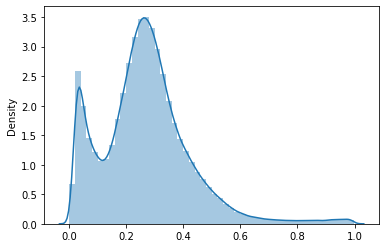

In [25]:
import seaborn as sns
sns.distplot(pre/10)